# LDA-Based Topic Modeling for Analyzing Software Engineering Skills and Competencies for the digital payment industry in Hong Kong

## Load data set

In [7]:
import pandas as pd

csv_filename = "20230513_213918+0000"

# Read the CSV file into a pandas DataFrame
job_advertisements = pd.read_csv(f'./data/{csv_filename}.csv')

# Remove non-essential columns
job_advertisements = job_advertisements.loc[:, ~job_advertisements.columns.str.contains('^Unnamed')]
job_advertisements = job_advertisements.drop(columns=['id', 'source', 'job_title', 'created_at'], axis=1)

# Print head
job_advertisements.head()


,job_description
0,<ul><li><span>Have Bachelor's Degree in IT-rel...
1,<br><br>• Bachelor’s degree in Computer Scienc...
2,"</p><ul><li><span style=""font-size:10pt"">Degre..."
3,<br> Min. 5 years relevant development experie...
4,</h4> <ul> <li>Excellent at analytical think...


## Data Preprocessing



### Remove all HTML tags

In [8]:
import re

HTML_TAG_REGEX = re.compile('<.*?>')

def remove_html_tags(html: str) -> str:
    if html is None or len(html) == 0:
        return html
        
    return re.sub(HTML_TAG_REGEX, ' ', html).strip()    

# Remove all HTML tags
job_advertisements['job_description'] = job_advertisements['job_description'].map(lambda html: remove_html_tags(html))

# Print head
job_advertisements['job_description'].head()


0    Have Bachelor's Degree in IT-related disciplin...
1    • Bachelor’s degree in Computer Science, Telec...
2    Degree or above in IT or any relevant discipli...
3    Min. 5 years relevant development experience p...
4    Excellent at analytical thinking and problem-s...
Name: job_description, dtype: object

### Remove all stop words, punctuation and symbols

In [9]:
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

CHARACTER_AND_EMPTY_SPACE_REGEX = re.compile('[^\w\s]')
STOP_WORDS_SET = set(stopwords.words('english'))

def remove_stop_words(text: str) -> str:
    if text is None or len(text) == 0:
        return text
        
    word_tokens = word_tokenize(text)
    filtered_sentence_word_list = [w for w in word_tokens if not w.lower() in STOP_WORDS_SET]
    return ' '.join(filtered_sentence_word_list)


def remove_punctuation_and_symbols(text:str) -> str:
    if text is None or len(text) == 0:
        return text
    
    return re.sub(CHARACTER_AND_EMPTY_SPACE_REGEX, ' ', text)

# Remove all stop words
job_advertisements['job_description'] = job_advertisements['job_description'].map(lambda description: remove_stop_words(description))

# Remove all punctuation and symbols
job_advertisements['job_description'] = job_advertisements['job_description'].map(lambda description: remove_punctuation_and_symbols(description))

# Print head
job_advertisements['job_description'].head()

0    Bachelor  s Degree IT related disciplines equi...
1      Bachelor   degree Computer Science   Telecom...
2    Degree relevant disciplines least 5 years   so...
3    Min   5 years relevant development experience ...
4    Excellent analytical thinking problem solving ...
Name: job_description, dtype: object

### Convert to lowercase

In [10]:
# Convert all descriptions to lowercase
job_advertisements['job_description'] = job_advertisements['job_description'].map(lambda description: description.lower())

# Print head
job_advertisements['job_description'].head()

0    bachelor  s degree it related disciplines equi...
1      bachelor   degree computer science   telecom...
2    degree relevant disciplines least 5 years   so...
3    min   5 years relevant development experience ...
4    excellent analytical thinking problem solving ...
Name: job_description, dtype: object


### Tokenization

In [11]:
from gensim.utils import simple_preprocess

def sent_to_words(sentences: str):
    for sentence in sentences:
        yield(simple_preprocess(str(sentence), deacc=True))

# Tokenize
job_advertisements_data = job_advertisements['job_description'].values.tolist()
job_advertisements_data_words = list(sent_to_words(job_advertisements_data))

# Print head
print(job_advertisements_data_words[:1][0][:30])

['bachelor', 'degree', 'it', 'related', 'disciplines', 'equivalent', 'computer', 'science', 'computer', 'engineering', 'highly', 'preferrable', 'accept', 'fresh', 'graduate', 'bachelor', 'degree', 'java', 'skills', 'combination', 'experience', 'including', 'limited', 'following', 'items', 'web', 'based', 'database', 'application', 'development']


### Prepare trigram models 

In [12]:
import gensim

# Build the bigram and trigram models
bigram = gensim.models.Phrases(job_advertisements_data_words, min_count=5, threshold=100)
trigram = gensim.models.Phrases(bigram[job_advertisements_data_words], threshold=100)

bigram_models = gensim.models.phrases.Phraser(bigram)
trigram_models = gensim.models.phrases.Phraser(trigram)

### Perform Lemmatization

In [13]:
# !python -m spacy download en_core_web_sm
import spacy

def make_bigrams(texts: str) -> list:
    return [bigram_models[doc] for doc in texts]

def make_trigrams(texts: str) -> list:
    return [trigram_models[bigram_models[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

# From Bigrams
job_advertisements_bigrams = make_bigrams(job_advertisements_data_words)

# From Trigrams
job_advertisements_trigrams = make_trigrams(job_advertisements_data_words)

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
nlp = spacy.load("en_core_web_sm", disable=['parser', 'ner'])

# Perform Lemmatization
preprocessed_job_advertisements_bigrams = lemmatization(job_advertisements_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])
preprocessed_job_advertisements_trigrams = lemmatization(job_advertisements_trigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

# Print head
print(preprocessed_job_advertisements_trigrams[:1][0])
print(preprocessed_job_advertisements_trigrams[:2][1])
print(preprocessed_job_advertisements_trigrams[:3][2])
print(preprocessed_job_advertisements_trigrams[:4][3])
print(preprocessed_job_advertisements_trigrams[:5][4])

['bachelor', 'degree', 'relate', 'discipline', 'equivalent', 'computer', 'science', 'computer', 'engineering', 'highly', 'preferrable', 'accept', 'fresh', 'graduate', 'bachelor', 'degree', 'skill', 'combination', 'experience', 'include', 'limited', 'following_item', 'web', 'base', 'database', 'application', 'development', 'solid', 'skill', 'web', 'server', 'programming', 'xml', 'experience', 'following_item', 'preferrable', 'implementation', 'web', 'base', 'database', 'application', 'use', 'rapid', 'application', 'development', 'agile', 'software', 'development', 'methodology', 'implementation', 'maintenance', 'common', 'service', 'message', 'notification', 'online', 'payment', 'client', 'authentication', 'use', 'digital', 'certificate', 'provide', 'egis', 'implementation', 'maintenance', 'system', 'support', 'payment', 'use', 'digital', 'wallet', 'implementation', 'maintenance', 'system', 'adopt', 'virtualization', 'technology', 'host', 'govcloud', 'egi', 'communicate', 'level', 'engl

### Convert to document term matrix (DTM)

In [14]:
import gensim.corpora as corpora

# Create Dictionary
id2word = corpora.Dictionary(preprocessed_job_advertisements_trigrams)

# Create Corpus
texts = preprocessed_job_advertisements_trigrams

# Convert to document term matrix (DTM)
corpus = [id2word.doc2bow(text) for text in texts]

id_words = [[(id2word[id], count) for id, count in line] for line in corpus]
print(id_words[0])


[('accept', 1), ('adopt', 1), ('agile', 1), ('application', 3), ('authentication', 1), ('bachelor', 2), ('base', 2), ('certificate', 1), ('client', 1), ('combination', 1), ('common', 1), ('communicate', 1), ('computer', 2), ('database', 2), ('degree', 2), ('development', 3), ('digital', 2), ('discipline', 1), ('egi', 1), ('egis', 1), ('engineering', 1), ('english', 2), ('equivalent', 1), ('experience', 2), ('following_item', 2), ('fresh', 1), ('govcloud', 1), ('graduate', 1), ('highly', 1), ('host', 1), ('implementation', 4), ('include', 1), ('level', 1), ('limited', 1), ('maintenance', 3), ('message', 1), ('methodology', 1), ('notification', 1), ('online', 1), ('payment', 2), ('preferrable', 2), ('proficient', 1), ('programming', 1), ('provide', 1), ('rapid', 1), ('relate', 1), ('science', 1), ('server', 1), ('service', 1), ('skill', 2), ('software', 1), ('solid', 1), ('support', 1), ('system', 2), ('technical', 1), ('technology', 1), ('use', 3), ('virtualization', 1), ('wallet', 1), 

## Data Interpretation

### Find term occurrences and its frequency

In [15]:
import math
import pandas as pd

def replace_all_spaces_to_underscore(word):
    return '_'.join(word.split())

def compute_term_frequency(word_dict, doc):
    tf_dict = {}
    corpus_count = len(doc)

    for word, count in word_dict.items():
        tf_dict[word] = count / float(corpus_count)

    return tf_dict

def compute_inverse_document_frequency(doc_list):
    idf_dict = {}
    N = len(doc_list)

    idf_dict = dict.fromkeys(doc_list[0].keys(), 0)
    for word, val in idf_dict.items():
        idf_dict[word] = math.log10(N / (float(val) + 1))
    
    return idf_dict

def compute_tfidf(tf_bow, idfs):
    tfidf = {}
    for word, val in tf_bow.items():
        tfidf[word] = val * idfs[word]
    return tfidf


### Get term occurrences and its frequencies for programming, scripting and markup languages

In [16]:
programming_scripting_and_markup_languages_csv_filename = 'Programming, scripting, and markup language'

# Read the CSV file into a pandas DataFrame
programming_scripting_and_markup_languages = pd.read_csv(f'./data/Stack_Overflow_Survey_2022/{programming_scripting_and_markup_languages_csv_filename}.csv')

# Convert all labels to lowercase
programming_scripting_and_markup_languages['Programming, scripting, and markup language'] = programming_scripting_and_markup_languages['Programming, scripting, and markup language'].map(lambda label: label.lower())

# Print head
# programming_scripting_and_markup_languages.head()

programming_scripting_and_markup_languages_set = set(programming_scripting_and_markup_languages['Programming, scripting, and markup language'])
for key in programming_scripting_and_markup_languages_set:
    programming_scripting_and_markup_languages_set.remove(key)
    programming_scripting_and_markup_languages_set.add(replace_all_spaces_to_underscore(key))

programming_scripting_and_markup_languages_count = []
programming_scripting_and_markup_languages_word_dicts = []
programming_scripting_and_markup_languages_tfs = []

for idx, id_word_in_doc in enumerate(id_words):
    word_dict = dict.fromkeys(programming_scripting_and_markup_languages_set, 0)

    for word, count in id_word_in_doc:
        if word in programming_scripting_and_markup_languages_set:
            word_dict[word] += 1
    
    programming_scripting_and_markup_languages_count.append(word_dict)
    programming_scripting_and_markup_languages_word_dicts.append(word_dict)
    programming_scripting_and_markup_languages_tfs.append(compute_term_frequency(word_dict, preprocessed_job_advertisements_trigrams[idx]))

programming_scripting_and_markup_languages_idfs = compute_inverse_document_frequency(programming_scripting_and_markup_languages_word_dicts)
programming_scripting_and_markup_languages_tfidfs = [compute_tfidf(tf, programming_scripting_and_markup_languages_idfs) for tf in programming_scripting_and_markup_languages_tfs]

programming_scripting_and_markup_languages_count = dict.fromkeys(programming_scripting_and_markup_languages_word_dicts[0], 0)
for word_dict in programming_scripting_and_markup_languages_word_dicts:
    for word in word_dict:
        programming_scripting_and_markup_languages_count[word] += word_dict[word]

print(programming_scripting_and_markup_languages_count)

{'julia': 0, 'go': 3, 'dart': 0, 'scala': 0, 'groovy': 0, 'lisp': 0, 'vba': 0, 'bash/shell': 0, 'matlab': 0, 'c++': 0, 'powershell': 0, 'crystal': 0, 'c#': 0, 'html/css': 0, 'ruby': 1, 'solidity': 0, 'apl': 0, 'delphi': 0, 'swift': 0, 'elixir': 0, 'perl': 0, 'assembly': 0, 'fortran': 0, 'sql': 4, 'typescript': 3, 'php': 4, 'cobol': 1, 'javascript': 4, 'rust': 0, 'java': 5, 'f#': 0, 'haskell': 0, 'python': 0, 'objective-c': 0, 'clojure': 0, 'erlang': 0, 'ocaml': 0, 'c': 0, 'kotlin': 0, 'r': 0, 'sas': 0, 'lua': 0}


### Get term occurrences and its frequencies for databases

In [17]:
databases_csv_filename = 'Databases'

# Read the CSV file into a pandas DataFrame
databases = pd.read_csv(f'./data/Stack_Overflow_Survey_2022/{databases_csv_filename}.csv')

# Convert all labels to lowercase
databases['Databases'] = databases['Databases'].map(lambda label: label.lower())

# Print head
# databases.head()

databases_set = set(databases['Databases'])
for key in databases_set:
    databases_set.remove(key)
    databases_set.add(replace_all_spaces_to_underscore(key))
# print(databases_set)

databases_count = []
databases_word_dicts = []
databases_tfs = []

for idx, id_word_in_doc in enumerate(id_words):
    word_dict = dict.fromkeys(databases_set, 0)

    for word, count in id_word_in_doc:
        if word in databases_set:
            word_dict[word] += 1
    
    databases_count.append(word_dict)
    databases_word_dicts.append(word_dict)
    databases_tfs.append(compute_term_frequency(word_dict, preprocessed_job_advertisements_trigrams[idx]))

databases_idfs = compute_inverse_document_frequency(databases_word_dicts)
databases_tfidfs = [compute_tfidf(tf, databases_idfs) for tf in databases_tfs]

databases_count = dict.fromkeys(databases_word_dicts[0], 0)
for word_dict in databases_word_dicts:
    for word in word_dict:
        databases_count[word] += word_dict[word]

print(databases_count)

{'cloud_firestore': 0, 'microsoft_sql_server': 0, 'couchbase': 0, 'firebase_realtime_database': 0, 'couchdb': 0, 'neo4j': 0, 'elasticsearch': 0, 'postgresql': 5, 'mongodb': 1, 'mariadb': 0, 'oracle': 10, 'ibm_db2': 0, 'dynamodb': 0, 'mysql': 4, 'redis': 0, 'cassandra': 0, 'sqlite': 0}


### Get term occurrences and its frequencies for cloud platforms

In [18]:
cloud_platforms_csv_filename = 'Cloud platforms'

# Read the CSV file into a pandas DataFrame
cloud_platforms = pd.read_csv(f'./data/Stack_Overflow_Survey_2022/{cloud_platforms_csv_filename}.csv')

# Convert all labels to lowercase
cloud_platforms['Cloud platforms'] = cloud_platforms['Cloud platforms'].map(lambda label: label.lower())

# Print head
# cloud_platforms.head()

cloud_platforms_set = set(cloud_platforms['Cloud platforms'])
for key in cloud_platforms_set:
    cloud_platforms_set.remove(key)
    cloud_platforms_set.add(replace_all_spaces_to_underscore(key))
# print(cloud_platforms_set)

cloud_platforms_count = []
cloud_platforms_word_dicts = []
cloud_platforms_tfs = []

for idx, id_word_in_doc in enumerate(id_words):
    word_dict = dict.fromkeys(cloud_platforms_set, 0)

    for word, count in id_word_in_doc:
        if word in cloud_platforms_set:
            word_dict[word] += 1
    
    cloud_platforms_count.append(word_dict)
    cloud_platforms_word_dicts.append(word_dict)
    cloud_platforms_tfs.append(compute_term_frequency(word_dict, preprocessed_job_advertisements_trigrams[idx]))

cloud_platforms_idfs = compute_inverse_document_frequency(cloud_platforms_word_dicts)
cloud_platforms_tfidfs = [compute_tfidf(tf, cloud_platforms_idfs) for tf in cloud_platforms_tfs]

cloud_platforms_count = dict.fromkeys(cloud_platforms_word_dicts[0], 0)
for word_dict in cloud_platforms_word_dicts:
    for word in word_dict:
        cloud_platforms_count[word] += word_dict[word]

print(cloud_platforms_count)

{'firebase': 0, 'ovh': 0, 'aws': 0, 'oracle_cloud_infrastructure': 0, 'colocation': 0, 'managed_hosting': 0, 'digitalocean': 0, 'ibm_cloud_or_watson': 0, 'microsoft_azure': 0, 'heroku': 0, 'linode': 0, 'openstack': 0, 'vmware': 0, 'google_cloud': 0}


### Get term occurrences and its frequencies for web frameworks and technologies

In [19]:
web_frameworks_and_technologies_csv_filename = 'Web frameworks and technologies'

# Read the CSV file into a pandas DataFrame
web_frameworks_and_technologies = pd.read_csv(f'./data/Stack_Overflow_Survey_2022/{web_frameworks_and_technologies_csv_filename}.csv')

# Convert all labels to lowercase
web_frameworks_and_technologies['Web frameworks and technologies'] = web_frameworks_and_technologies['Web frameworks and technologies'].map(lambda label: label.lower())

# Print head
# web_frameworks_and_technologies.head()

web_frameworks_and_technologies_set = set(web_frameworks_and_technologies['Web frameworks and technologies'])
for key in web_frameworks_and_technologies_set:
    web_frameworks_and_technologies_set.remove(key)
    web_frameworks_and_technologies_set.add(replace_all_spaces_to_underscore(key))
# print(web_frameworks_and_technologies_set)

web_frameworks_and_technologies_count = []
web_frameworks_and_technologies_word_dicts = []
web_frameworks_and_technologies_tfs = []

for idx, id_word_in_doc in enumerate(id_words):
    word_dict = dict.fromkeys(web_frameworks_and_technologies_set, 0)

    for word, count in id_word_in_doc:
        if word in web_frameworks_and_technologies_set:
            word_dict[word] += 1
    
    web_frameworks_and_technologies_count.append(word_dict)
    web_frameworks_and_technologies_word_dicts.append(word_dict)
    web_frameworks_and_technologies_tfs.append(compute_term_frequency(word_dict, preprocessed_job_advertisements_trigrams[idx]))

web_frameworks_and_technologies_idfs = compute_inverse_document_frequency(web_frameworks_and_technologies_word_dicts)
web_frameworks_and_technologies_tfidfs = [compute_tfidf(tf, web_frameworks_and_technologies_idfs) for tf in web_frameworks_and_technologies_tfs]

web_frameworks_and_technologies_count = dict.fromkeys(web_frameworks_and_technologies_word_dicts[0], 0)
for word_dict in web_frameworks_and_technologies_word_dicts:
    for word in word_dict:
        web_frameworks_and_technologies_count[word] += word_dict[word]

print(web_frameworks_and_technologies_count)

{'deno': 0, 'svelte': 0, 'vue.js': 0, 'drupal': 0, 'symfony': 0, 'gatsby': 0, 'laravel': 0, 'asp.net': 0, 'express': 0, 'play_framework': 0, 'asp.net_core': 0, 'next.js': 0, 'ruby_on_rails': 0, 'node.js': 0, 'phoenix': 0, 'blazor': 0, 'nuxt.js': 0, 'angular.js': 0, 'react.js': 0, 'flask': 0, 'jquery': 0, 'fastify': 0, 'angular': 4, 'fastapi': 0, 'django': 0}


### Get term occurrences and its frequencies for other frameworks and technologies

In [20]:
other_frameworks_and_libraries_csv_filename = 'Other frameworks and libraries'

# Read the CSV file into a pandas DataFrame
other_frameworks_and_libraries = pd.read_csv(f'./data/Stack_Overflow_Survey_2022/{other_frameworks_and_libraries_csv_filename}.csv')

# Convert all labels to lowercase
other_frameworks_and_libraries['Other frameworks and libraries'] = other_frameworks_and_libraries['Other frameworks and libraries'].map(lambda label: label.lower())

# Print head
# other_frameworks_and_libraries.head()

other_frameworks_and_libraries_set = set(other_frameworks_and_libraries['Other frameworks and libraries'])
for key in other_frameworks_and_libraries_set:
    other_frameworks_and_libraries_set.remove(key)
    other_frameworks_and_libraries_set.add(replace_all_spaces_to_underscore(key))
# print(other_frameworks_and_libraries_set)

other_frameworks_and_libraries_count = []
other_frameworks_and_libraries_word_dicts = []
other_frameworks_and_libraries_tfs = []

for idx, id_word_in_doc in enumerate(id_words):
    word_dict = dict.fromkeys(other_frameworks_and_libraries_set, 0)

    for word, count in id_word_in_doc:
        if word in other_frameworks_and_libraries_set:
            word_dict[word] += 1
    
    other_frameworks_and_libraries_count.append(word_dict)
    other_frameworks_and_libraries_word_dicts.append(word_dict)
    other_frameworks_and_libraries_tfs.append(compute_term_frequency(word_dict, preprocessed_job_advertisements_trigrams[idx]))

other_frameworks_and_libraries_idfs = compute_inverse_document_frequency(other_frameworks_and_libraries_word_dicts)
other_frameworks_and_libraries_tfidfs = [compute_tfidf(tf, other_frameworks_and_libraries_idfs) for tf in other_frameworks_and_libraries_tfs]

other_frameworks_and_libraries_count = dict.fromkeys(other_frameworks_and_libraries_word_dicts[0], 0)
for word_dict in other_frameworks_and_libraries_word_dicts:
    for word in word_dict:
        other_frameworks_and_libraries_count[word] += word_dict[word]

print(other_frameworks_and_libraries_count)

{'hugging_face_transformers': 0, 'apache_kafka': 0, 'qt': 0, 'keras': 0, 'torch/pytorch': 0, '.net': 0, 'tensorflow': 0, 'pandas': 0, 'flutter': 2, 'gtk': 0, 'apache_spark': 0, 'spring': 4, 'xamarin': 0, 'ionic': 0, 'react_native': 0, 'capacitor': 0, 'hadoop': 0, 'numpy': 0, 'scikit-learn': 0, 'tidyverse': 0, 'cordova': 0, 'electron': 0, 'uno_platform': 0}


### Get term occurrences and its frequencies for other tools

In [21]:
other_tools_csv_filename = 'Other tools'

# Read the CSV file into a pandas DataFrame
other_tools = pd.read_csv(f'./data/Stack_Overflow_Survey_2022/{other_tools_csv_filename}.csv')

# Convert all labels to lowercase
other_tools['Other tools'] = other_tools['Other tools'].map(lambda label: label.lower())

# Print head
# other_tools.head()

other_tools_set = set(other_tools['Other tools'])
for key in other_tools_set:
    other_tools_set.remove(key)
    other_tools_set.add(replace_all_spaces_to_underscore(key))
# print(other_tools_set)

other_tools_count = []
other_tools_word_dicts = []
other_tools_tfs = []

for idx, id_word_in_doc in enumerate(id_words):
    word_dict = dict.fromkeys(other_tools_set, 0)

    for word, count in id_word_in_doc:
        if word in other_tools_set:
            word_dict[word] += 1
    
    other_tools_count.append(word_dict)
    other_tools_word_dicts.append(word_dict)
    other_tools_tfs.append(compute_term_frequency(word_dict, preprocessed_job_advertisements_trigrams[idx]))

other_tools_idfs = compute_inverse_document_frequency(other_tools_word_dicts)
other_tools_tfidfs = [compute_tfidf(tf, other_tools_idfs) for tf in other_tools_tfs]

other_tools_count = dict.fromkeys(other_tools_word_dicts[0], 0)
for word_dict in other_tools_word_dicts:
    for word in word_dict:
        other_tools_count[word] += word_dict[word]

print(other_tools_count)

{'npm': 0, 'yarn': 0, 'docker': 6, 'unreal_engine': 0, 'puppet': 0, 'chef': 0, 'flow': 3, 'pulumi': 0, 'ansible': 0, 'unity_3d': 0, 'homebrew': 0, 'kubernetes': 0, 'terraform': 2}


### Aggregate all of occurrences and frequency together

In [44]:
merged_dict = {}

counter_results = [
    programming_scripting_and_markup_languages_count,
    databases_count,
    cloud_platforms_count,
    web_frameworks_and_technologies_count,
    other_frameworks_and_libraries_count,
    other_tools_count,
]

for results in counter_results:
    for key, val in results.items():
        if key in merged_dict:
            merged_dict[key] += val
        else:
            merged_dict[key] = val
    
sorted_merged_dict = sorted(merged_dict.items(), key=lambda x: x[1], reverse=True)
print(sorted_merged_dict)


[('oracle', 10), ('docker', 6), ('java', 5), ('postgresql', 5), ('sql', 4), ('php', 4), ('javascript', 4), ('mysql', 4), ('angular', 4), ('spring', 4), ('go', 3), ('typescript', 3), ('flow', 3), ('flutter', 2), ('terraform', 2), ('ruby', 1), ('cobol', 1), ('mongodb', 1), ('julia', 0), ('dart', 0), ('scala', 0), ('groovy', 0), ('lisp', 0), ('vba', 0), ('bash/shell', 0), ('matlab', 0), ('c++', 0), ('powershell', 0), ('crystal', 0), ('c#', 0), ('html/css', 0), ('solidity', 0), ('apl', 0), ('delphi', 0), ('swift', 0), ('elixir', 0), ('perl', 0), ('assembly', 0), ('fortran', 0), ('rust', 0), ('f#', 0), ('haskell', 0), ('python', 0), ('objective-c', 0), ('clojure', 0), ('erlang', 0), ('ocaml', 0), ('c', 0), ('kotlin', 0), ('r', 0), ('sas', 0), ('lua', 0), ('cloud_firestore', 0), ('microsoft_sql_server', 0), ('couchbase', 0), ('firebase_realtime_database', 0), ('couchdb', 0), ('neo4j', 0), ('elasticsearch', 0), ('mariadb', 0), ('ibm_db2', 0), ('dynamodb', 0), ('redis', 0), ('cassandra', 0), (

### Calculate the optimal number of topics

In [47]:
import tqdm
import numpy as np
from gensim.models import CoherenceModel

# supporting function
def compute_coherence_values(corpus, dictionary, k, a, b):
    
    lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                           id2word=dictionary,
                                           num_topics=k, 
                                           random_state=100,
                                           chunksize=100,
                                           passes=10,
                                           alpha=a,
                                           eta=b)
    
    coherence_model_lda = CoherenceModel(model=lda_model, texts=texts, dictionary=id2word, coherence='c_v')
    
    return coherence_model_lda.get_coherence()

grid = {}
grid['Validation_Set'] = {}

# Topics range
min_topics = 2
max_topics = 11
step_size = 1
topics_range = range(min_topics, max_topics, step_size)

# Alpha parameter
alpha = list(np.arange(0.01, 1, 0.3))
alpha.append('symmetric')
alpha.append('asymmetric')

# Beta parameter
beta = list(np.arange(0.01, 1, 0.3))
beta.append('symmetric')

# Validation sets
num_of_docs = len(corpus)
corpus_sets = [gensim.utils.ClippedCorpus(corpus, int(num_of_docs*0.75)), 
               corpus]

corpus_title = ['75% Corpus', '100% Corpus']

model_results = {
    'Validation_Set': [],
    'Topics': [],
    'Alpha': [],
    'Beta': [],
    'Coherence': []
}

# Can take a long time to run
if 1 == 1:
    pbar = tqdm.tqdm(total=(len(beta)*len(alpha)*len(topics_range)*len(corpus_title)))
    
    # iterate through validation corpuses
    for i in range(len(corpus_sets)):
        # iterate through number of topics
        for k in topics_range:
            # iterate through alpha values
            for a in alpha:
                # iterare through beta values
                for b in beta:
                    # get the coherence score for the given parameters
                    cv = compute_coherence_values(corpus=corpus_sets[i], dictionary=id2word, 
                                                  k=k, a=a, b=b)
                    # Save the model results
                    model_results['Validation_Set'].append(corpus_title[i])
                    model_results['Topics'].append(k)
                    model_results['Alpha'].append(a)
                    model_results['Beta'].append(b)
                    model_results['Coherence'].append(cv)
                    
                    pbar.update(1)
    pd.DataFrame(model_results).to_csv('./lda_tuning_results.csv', index=False)
    pbar.close()


100%|██████████| 540/540 [29:03<00:00,  3.23s/it]


### LDA-based Topic Modeling


In [31]:
from pprint import pprint

num_topics = 10

# Build LDA model
lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                       id2word=id2word,
                                       num_topics=num_topics,
                                       random_state=100,
                                       chunksize=100,
                                       passes=10,
                                       iterations=1500,
                                       per_word_topics=True)

doc_lda = lda_model[corpus]

# Print the Keyword in the 10 topics
pprint(lda_model.print_topics())

[(0,
  '0.021*"skill" + 0.017*"experience" + 0.013*"knowledge" + 0.013*"software" + '
  '0.009*"learn" + 0.009*"technology" + 0.009*"strong" + 0.009*"environment" + '
  '0.009*"system" + 0.009*"agile"'),
 (1,
  '0.048*"knowledge" + 0.029*"experience" + 0.020*"skill" + 0.020*"good" + '
  '0.019*"business" + 0.019*"framework" + 0.019*"php" + 0.010*"payment" + '
  '0.010*"methodology" + 0.010*"write"'),
 (2,
  '0.022*"relate" + 0.022*"good" + 0.022*"experience" + 0.011*"tool" + '
  '0.011*"position" + 0.011*"card" + 0.011*"payment" + 0.011*"banking" + '
  '0.011*"degree" + 0.011*"year"'),
 (3,
  '0.038*"development" + 0.032*"information" + 0.029*"experience" + '
  '0.026*"relate" + 0.023*"familiar" + 0.021*"discipline" + 0.020*"technology" '
  '+ 0.019*"advantage" + 0.019*"good" + 0.018*"computer"'),
 (4,
  '0.054*"experience" + 0.026*"knowledge" + 0.026*"good" + 0.020*"strong" + '
  '0.019*"development" + 0.018*"design" + 0.015*"year" + 0.015*"work" + '
  '0.015*"software" + 0.013*"payme

### Topic Extraction

In [32]:
pd.set_option('display.max_column', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_seq_items', None)
pd.set_option('display.max_colwidth', 1000)
pd.set_option('expand_frame_repr', True)

num_terms = 10

topics = [ [(id2word[wid], s) for (wid, s) in lda_model.get_topic_terms(tid, topn=num_terms)] for tid in range(num_topics)]
# pprint(topics)

topics_df = pd.DataFrame([[term for term, wt in topic] for topic in topics], columns = ['Term'+str(i) for i in range(1, num_terms+1)], index=['Topic '+str(t) for t in range(1, num_topics+1)]).T
topics_df.head()

# Set column width
topics_df = pd.DataFrame([', '.join([term for term, wt in topic]) for topic in topics], columns = ['Terms per Topic'], index=['Topic'+str(t) for t in range(1, num_topics+1)])
topics_df

,Terms per Topic
Topic1,"skill, experience, knowledge, software, learn, technology, strong, environment, system, agile"
Topic2,"knowledge, experience, skill, good, business, framework, php, payment, methodology, write"
Topic3,"relate, good, experience, tool, position, card, payment, banking, degree, year"
Topic4,"development, information, experience, relate, familiar, discipline, technology, advantage, good, computer"
Topic5,"experience, knowledge, good, strong, development, design, year, work, software, payment"
Topic6,"experience, least, year, month, advantage, skill, post, technical, management, higher_diploma"
Topic7,"product, interface, company, responsible, develop, api, development, platform, solution, end"
Topic8,"experience, development, technology, year, application, skill, knowledge, science, relate, degree"
Topic9,"experience, skill, work, team, knowledge, ability, environment, communication, drive, excellent"
Topic10,"experience, development, application, implementation, web, system, skill, use, database, payment"


## Data Evaluation

### Calculate coherence measurement score

In [33]:
from gensim.models import CoherenceModel

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, 
                                    texts=texts, 
                                    dictionary=id2word,
                                    coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print(f'Coherence Score (mean): {coherence_lda}')

coherence_per_topics = coherence_model_lda.get_coherence_per_topic()
print('Coherence score per topic:')
pprint(coherence_per_topics)


Coherence Score (mean): 0.42312828981819084
Coherence score per topic:
[0.4550372576429077,
 0.3899241953906423,
 0.3726040723961272,
 0.4018098809211191,
 0.3990233459142809,
 0.5579836571444149,
 0.27789091121020826,
 0.48923538525206445,
 0.3667644528701802,
 0.5210097394399632]


### Visualize coherence score per topic

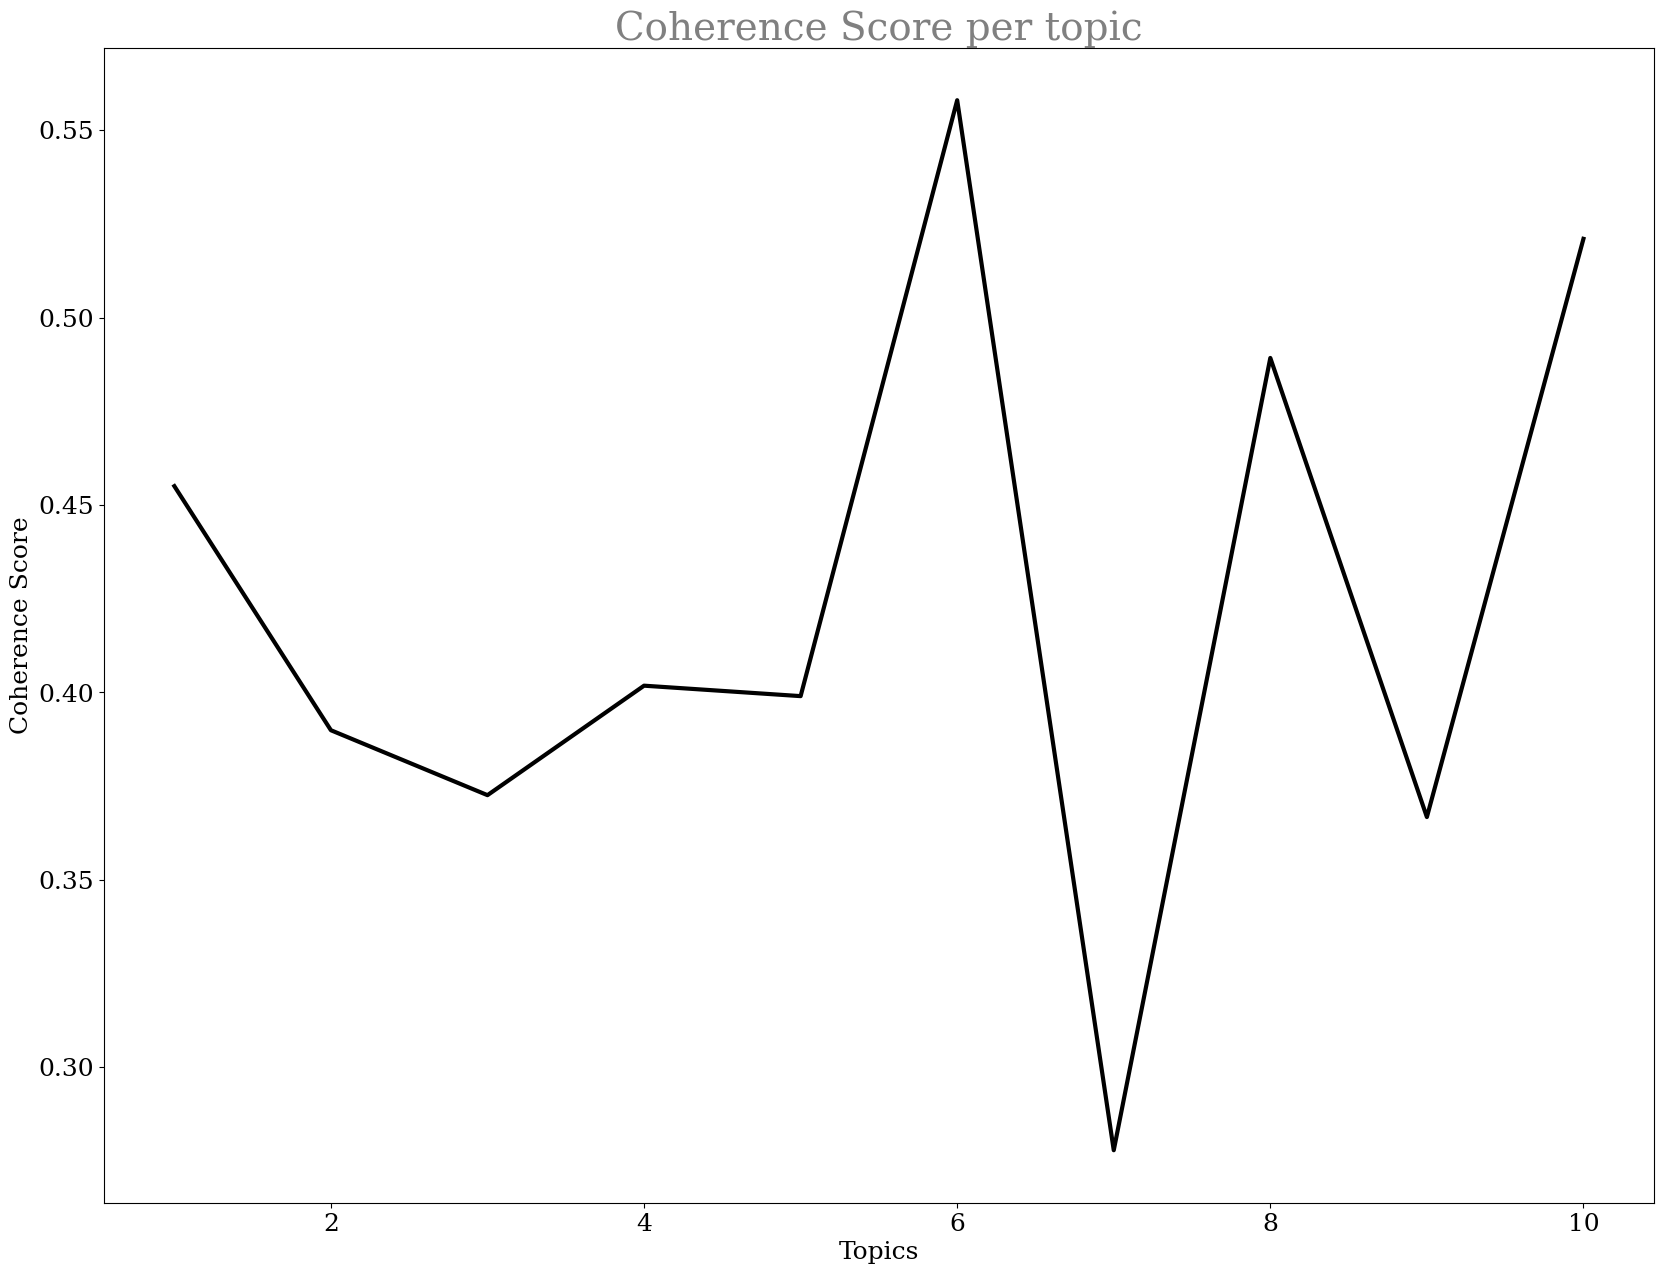

In [34]:
import matplotlib.pyplot as plt
import numpy as np

# lda_tuning_results = pd.read_csv('./lda_tuning_results.csv')
# lda_tuning_results = lda_tuning_results.drop(columns=['Validation_Set', 'Alpha', 'Beta'])
# lda_tuning_results.head()

# xpoints = np.array(lda_tuning_results['Topics'])
# ypoints = np.array(lda_tuning_results['Coherence'])

x_points = np.array([index + 1 for index in range(len(coherence_per_topics))])
y_points = np.array(coherence_per_topics)

plt.rcParams.update({
    'font.family': 'serif',
    'font.size': 18
})
plt.title('Coherence Score per topic', color='grey', fontsize=28)
plt.xlabel('Topics', fontsize=18)
plt.ylabel('Coherence Score', fontsize=18)
plt.plot(x_points, y_points, color='black', linewidth=3)
plt.show()

In [35]:
for idx, topic_coherence_val in enumerate(coherence_per_topics):
    print(f'Topic: {idx + 1} has Coherence Value of {topic_coherence_val}')

Topic: 1 has Coherence Value of 0.4550372576429077
Topic: 2 has Coherence Value of 0.3899241953906423
Topic: 3 has Coherence Value of 0.3726040723961272
Topic: 4 has Coherence Value of 0.4018098809211191
Topic: 5 has Coherence Value of 0.3990233459142809
Topic: 6 has Coherence Value of 0.5579836571444149
Topic: 7 has Coherence Value of 0.27789091121020826
Topic: 8 has Coherence Value of 0.48923538525206445
Topic: 9 has Coherence Value of 0.3667644528701802
Topic: 10 has Coherence Value of 0.5210097394399632


## Data Visualization

### PyLDAvis

In [36]:
import os
import pickle
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis

# Visualize the topics
pyLDAvis.enable_notebook()

LDAvis_data_filepath = os.path.join(f'./ldavis_tuned_{str(num_topics)}')

if 1 == 1:
    LDAvis_prepared = gensimvis.prepare(lda_model, corpus, id2word)
    with open(LDAvis_data_filepath, 'wb') as f:
        pickle.dump(LDAvis_prepared, f)

# Load the pre-prepared pyLDAvis data from disk
with open(LDAvis_data_filepath, 'rb') as f:
    LDAvis_prepared = pickle.load(f)

pyLDAvis.save_html(LDAvis_prepared, f'./ldavis_tuned_{str(num_topics)}.html')

LDAvis_prepared


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
9     -0.081798 -0.121912       1        1  39.546640
4     -0.123844  0.014560       2        1  26.950431
8      0.092927 -0.055311       3        1   7.952153
3     -0.147817 -0.015655       4        1   7.466544
0      0.022351 -0.027114       5        1   4.928191
5      0.003301  0.150633       6        1   3.994863
1      0.036110  0.075591       7        1   3.935942
2     -0.007245  0.044777       8        1   3.198539
6      0.113377 -0.075472       9        1   1.893006
7      0.092639  0.009902      10        1   0.133691, topic_info=                     Term        Freq       Total Category  logprob  loglift
23             experience  143.000000  143.000000  Default  30.0000  30.0000
125             knowledge   44.000000   44.000000  Default  29.0000  29.0000
203                  year   36.000000   36.000000  Default  28.0000  28.0000
215                 least   18.000000   18.000000  Default  27.0000  27.0000
112                  good   42.000000   42.000000  Default  26.0000  26.0000
15            development   70.000000   70.000000  Default  25.0000  25.0000
45                 relate   28.000000   28.000000  Default  24.0000  24.0000
49                  skill   49.000000   49.000000  Default  23.0000  23.0000
240               product   12.000000   12.000000  Default  22.0000  22.0000
204             advantage   17.000000   17.000000  Default  21.0000  21.0000
281           information   13.000000   13.000000  Default  20.0000  20.0000
17             discipline   25.000000   25.000000  Default  19.0000  19.0000
54              technical   20.000000   20.000000  Default  18.0000  18.0000
20            engineering   19.000000   19.000000  Default  17.0000  17.0000
8                  client   10.000000   10.000000  Default  16.0000  16.0000
50               software   31.000000   31.000000  Default  15.0000  15.0000
55             technology   37.000000   37.000000  Default  14.0000  14.0000
148              platform   11.000000   11.000000  Default  13.0000  13.0000
546                 month    6.000000    6.000000  Default  12.0000  12.0000
14                 degree   31.000000   31.000000  Default  11.0000  11.0000
56                    use   26.000000   26.000000  Default  10.0000  10.0000
12               computer   30.000000   30.000000  Default   9.0000   9.0000
30         implementation   26.000000   26.000000  Default   8.0000   8.0000
31                include   19.000000   19.000000  Default   7.0000   7.0000
46                science   26.000000   26.000000  Default   6.0000   6.0000
187                  team   22.000000   22.000000  Default   5.0000   5.0000
5                bachelor   17.000000   17.000000  Default   4.0000   4.0000
6                    base   15.000000   15.000000  Default   3.0000   3.0000
201                  work   39.000000   39.000000  Default   2.0000   2.0000
59                    web   34.000000   34.000000  Default   1.0000   1.0000
30         implementation   25.611408   26.207381   Topic1  -3.9969   0.9047
34            maintenance   18.070397   18.639473   Topic1  -4.3457   0.8967
40            preferrable   11.447678   12.016753   Topic1  -4.8022   0.8792
24         following_item   10.501571   11.070646   Topic1  -4.8884   0.8749
35                message    9.555458   10.124535   Topic1  -4.9828   0.8698
60                writing    6.717157    7.286232   Topic1  -5.3353   0.8464
7             certificate    6.717157    7.286232   Topic1  -5.3353   0.8464
9             combination    6.717157    7.286232   Topic1  -5.3353   0.8464
18                    egi    6.717157    7.286232   Topic1  -5.3353   0.8464
4          authentication    6.717156    7.286231   Topic1  -5.3353   0.8464
37           notification    6.717155    7.286230   Topic1  -5.3353   0.8464
33                limited    6.717155    7.286230   Topic1  -5.3353   0.846

### Words Cloud

/Users/ypinglai/Workspaces/UOEO/dissertation/venv/lib/python3.9/site-packages/wordcloud/wordcloud.py:106: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  self.colormap = plt.cm.get_cmap(colormap)


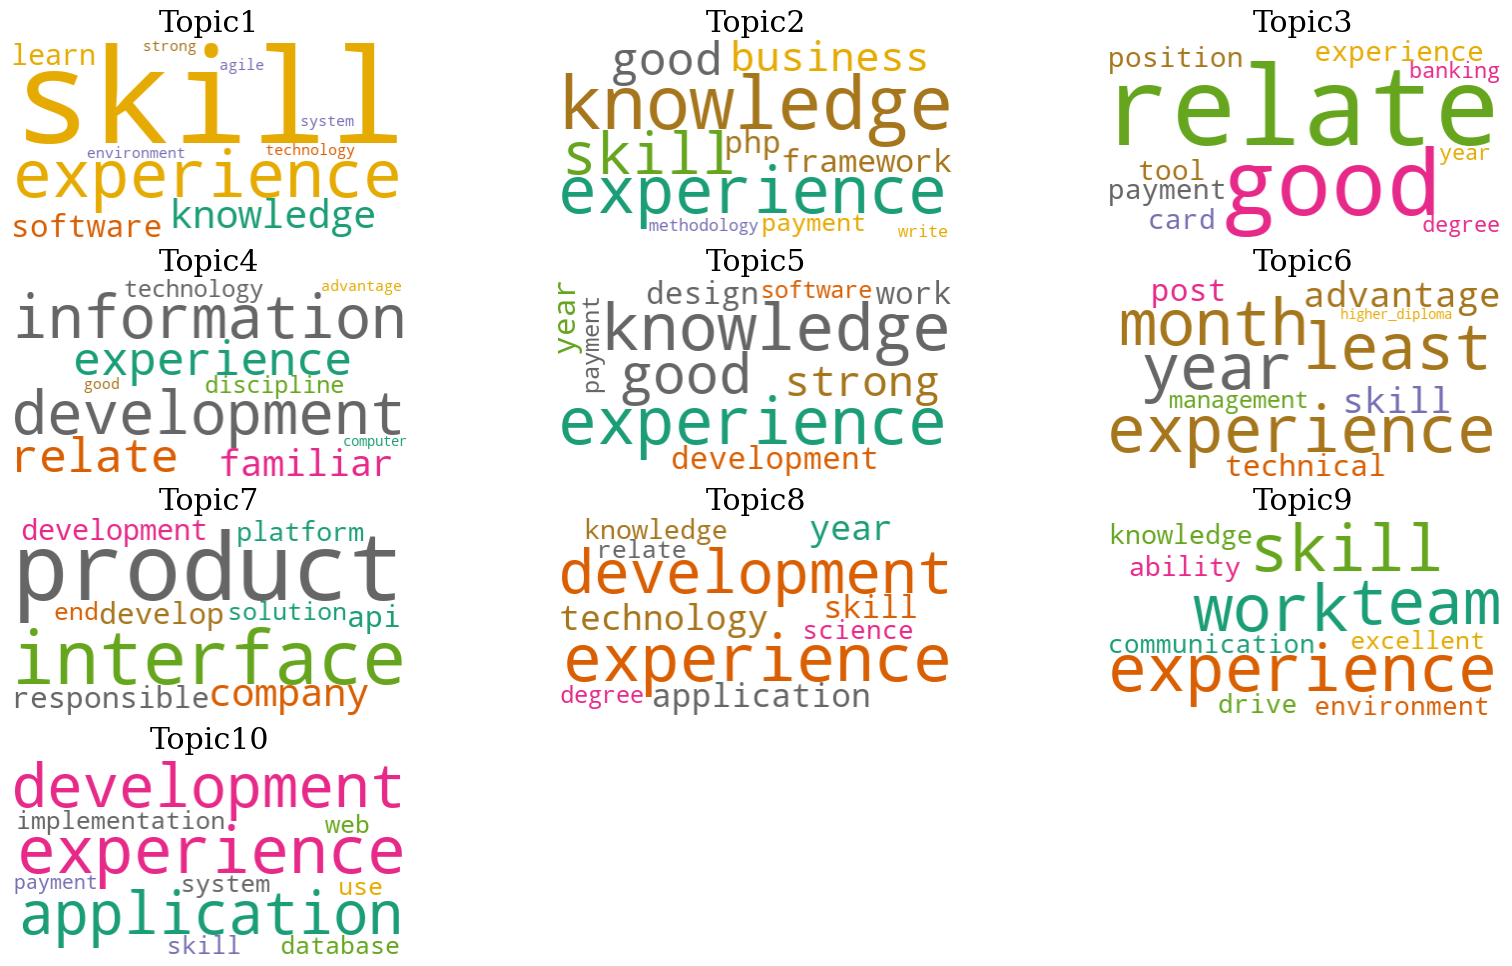

In [37]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud

# initiate wordcloud object
wc = WordCloud(background_color="white", colormap="Dark2", max_font_size=150, random_state=42)

# set the figure size
plt.rcParams['figure.figsize'] = [20, 15]

# Create subplots for each topic
for i in range(num_topics):

    wc.generate(text=topics_df["Terms per Topic"][i])
    
    plt.subplot(5, 3, i+1)
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.title(topics_df.index[i])

plt.show()